In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt
import hvplot.pandas
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from finta import TA
warnings.filterwarnings('ignore')

## Load Data

In [2]:
#Load the data
stock = "CAT"
start = dt.datetime(2010, 1, 1)
cat_df = web.DataReader(stock, 'yahoo', start) 

In [3]:
cat_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-01-04,59.189999,57.509998,57.650002,58.549999,7325600.0,42.120884
2010-01-05,59.439999,58.230000,58.549999,59.250000,5697200.0,42.624454
2010-01-06,59.930000,59.049999,59.180000,59.430000,4718800.0,42.753956
2010-01-07,59.900002,58.650002,59.299999,59.669998,5432900.0,42.926605
2010-01-08,60.369999,59.250000,59.250000,60.340000,6651300.0,43.408615


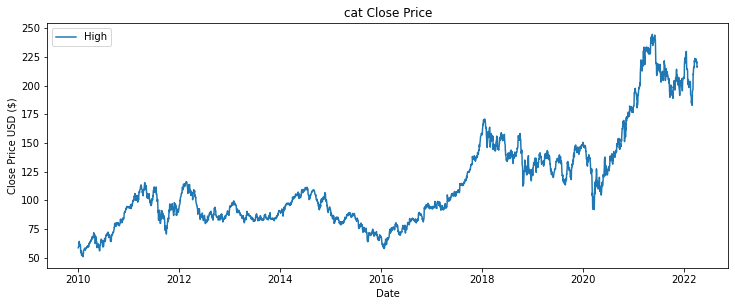

In [4]:
plt.figure(figsize=(12.2,4.5))
plt.plot(cat_df['Close'], label = 'Close Price')
plt.title('cat Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.legend(cat_df.columns.values, loc= 'upper left')
plt.show()

In [5]:
#Calculating the typical price
typical_price = (cat_df['Close'] + cat_df['High'] + cat_df['Low'])/ 3
typical_price

Date
2010-01-04     58.416665
2010-01-05     58.973333
2010-01-06     59.470000
2010-01-07     59.406667
2010-01-08     59.986666
                 ...    
2022-03-31    223.480001
2022-04-01    221.153336
2022-04-04    219.586670
2022-04-05    217.843333
2022-04-06    215.618337
Length: 3087, dtype: float64

## Get MFI Indicator

In [6]:
#Get the period
period = 14

In [7]:
#Calculate the MF
money_flow = typical_price * cat_df['Volume']
money_flow

Date
2010-01-04    4.279371e+08
2010-01-05    3.359829e+08
2010-01-06    2.806270e+08
2010-01-07    3.227505e+08
2010-01-08    3.989893e+08
                  ...     
2022-03-31    7.044313e+08
2022-04-01    5.789352e+08
2022-04-04    4.789844e+08
2022-04-05    7.803366e+08
2022-04-06    5.359002e+08
Length: 3087, dtype: float64

In [8]:
#Getting all of the positive and negative money flows
positive_flow = []
negative_flow = []

#Loop thru typical price

for i in range (1, len(typical_price)):
    if typical_price[i] > typical_price[i-1]:
        positive_flow.append(money_flow[i-1])
        negative_flow.append(0)
    elif typical_price[i] < typical_price[i-1]:
        negative_flow.append(money_flow[i-1])
        positive_flow.append(0)
    else:
        positive_flow.append(0)
        negative_flow.append(0)

In [9]:
#Get all of the positive and negative money flows within the 14-day time period
positive_mf = []
negative_mf = []

for i in range(period-1, len(positive_flow)):
    positive_mf.append(sum(positive_flow[i + 1- period : i+1]))
for i in range(period-1, len(negative_flow)):
    negative_mf.append(sum(negative_flow[i + 1- period : i+1]))

In [10]:
#Calculate the MFI

mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf) ))
mfi

array([35.31031593, 36.21645787, 30.16469039, ..., 57.48144176,
       49.92212704, 40.05707896])

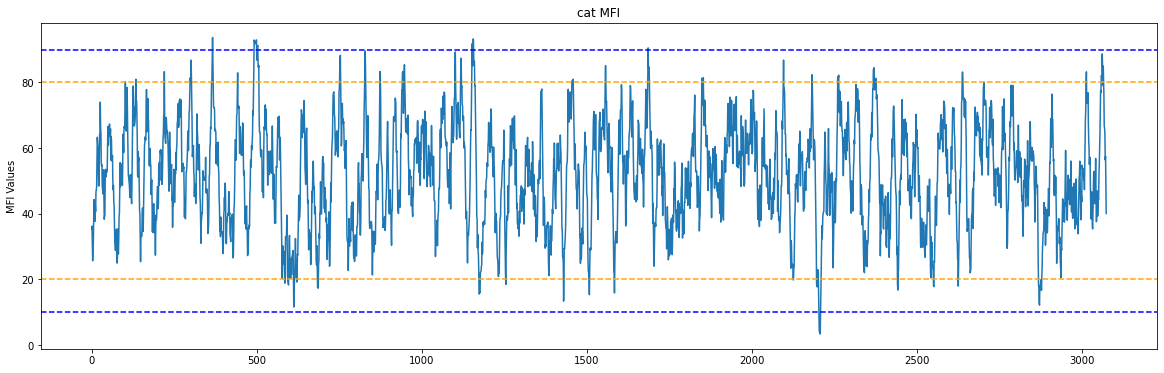

In [11]:
#Visualize the MFI
cat_df2 = pd.DataFrame()
cat_df2['MFI'] = mfi
#Create the plot
plt.figure(figsize=(20,6))
plt.plot(cat_df2['MFI'], label = 'MFI')
plt.axhline(10, linestyle = '--', color = 'blue')
plt.axhline(20, linestyle = '--', color = 'orange')
plt.axhline(80, linestyle = '--', color = 'orange')
plt.axhline(90, linestyle = '--', color = 'blue')
plt.title('cat MFI')
plt.ylabel('MFI Values')
plt.show()

In [12]:
#Create a new data frame
new_df = pd.DataFrame()
new_df = cat_df[period:]
new_df['MFI'] = mfi
new_df["Actual Returns"] = new_df["Close"].pct_change()

In [13]:
new_df.dropna(inplace=True)

In [14]:
new_df

,High,Low,Open,Close,Volume,Adj Close,MFI,Actual Returns
Date,,,,,,,,
2010-01-26,56.939999,54.599998,54.990002,55.849998,15218300.0,40.452621,36.216458,0.012876
2010-01-27,53.840000,51.029999,52.959999,53.439999,34041000.0,38.707043,30.164690,-0.043151
2010-01-28,53.830002,51.200001,53.820000,51.860001,15623100.0,37.562630,25.655007,-0.029566
2010-01-29,53.779999,52.000000,52.779999,52.240002,13962000.0,37.837887,29.111100,0.007327
2010-02-01,53.500000,52.500000,52.820000,52.939999,7159100.0,38.344891,31.285339,0.013400
...,...,...,...,...,...,...,...,...
2022-03-31,225.190002,222.429993,223.210007,222.820007,3152100.0,222.820007,64.370368,-0.001165
2022-04-01,225.520004,218.169998,224.350006,219.770004,2617800.0,219.770004,56.384526,-0.013688
2022-04-04,221.350006,216.600006,219.160004,220.809998,2181300.0,220.809998,57.481442,0.004732


In [15]:
# Create a trading algorithm using MACD
# Set the Signal column
new_df["Buy/Sell"] = 0.0

# Generate the trading signals 1 (entry) or -1 (exit) for a long position trading algorithm
# where 1 is when the MACD is greater than the SIGNAL
# where -1 is when the MACD is less than the SIGNAL
for index, row in new_df.iterrows():
    if row["MFI"] < 20:
        new_df.loc[index, "Buy/Sell"] = 1.0
    if row["MFI"] > 80:
        new_df.loc[index,"Buy/Sell"] = -1.0

# Add "Inflection Point" column to the DataFrame where MACD & SIGNAL cross (this will indicated Buy/Sell) 
#cat_combined_df["Indicator Point"] = 0.0
#cat_combined_df["Indicator Point"] = round(cat_combined_df["Buy/Sell"].diff() / 2)
new_df["Actual Returns"] = new_df["Close"].pct_change()

In [16]:
cat_algo_df = new_df[["Close", "MFI"]]
cat_algo_df.dropna(inplace=True)
cat_algo_df

,Close,MFI
Date,,
2010-01-26,55.849998,36.216458
2010-01-27,53.439999,30.164690
2010-01-28,51.860001,25.655007
2010-01-29,52.240002,29.111100
2010-02-01,52.939999,31.285339
...,...,...
2022-03-31,222.820007,64.370368
2022-04-01,219.770004,56.384526
2022-04-04,220.809998,57.481442


In [17]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

## Use INDICATOR to predict INDICATOR

In [18]:
# Predict Indicator Prices using a 5 day window of previous MFI values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 1 is the 'MFI' column
# Column index 0 is the `PCT Change` column
feature_column = 1
target_column = 1
X, y = window_data(cat_algo_df, window_size, feature_column, target_column)

In [19]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [20]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y_train)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [21]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

In [22]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 10
dropout_fraction = 0.2
# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output Layer
model.add(Dense(1))

In [23]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [24]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 10)             480       
_________________________________________________________________
dropout (Dropout)            (None, 5, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 2146 samples
Epoch 1/10
2146/2146 [==============================] - 8s 4ms/sample - loss: 0.0286
Epoch 2/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0160
Epoch 3/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0102
Epoch 4/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0079
Epoch 5/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0064
Epoch 6/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0062
Epoch 7/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0064
Epoch 8/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0064
Epoch 9/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0061
Epoch 10/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0060


In [26]:
# Evaluate the model
model.evaluate(X_test,y_test)

920/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.0046588452006487745

In [27]:
# Make some predictions
predicted = model.predict(X_test)

In [28]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [29]:
# Create a DataFrame of Real and Predicted values
results = pd.DataFrame({
    "Real MFI": real_prices.ravel(),
    "Predicted MFI": predicted_prices.ravel()
}, index = new_df.index[-len(real_prices): ]) 
results.head()

,Real MFI,Predicted MFI
Date,,
2018-08-13,58.913499,55.992561
2018-08-14,52.404137,57.263149
2018-08-15,46.646331,51.006073
2018-08-16,40.873236,45.927876
2018-08-17,40.773083,40.712154


In [30]:
# Plot the real vs predicted values as a line chart
results.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [50]:
# Create a DataFrame of Real and Predicted values
results = pd.DataFrame({
    "Real Close": new_df["Close"],
    "Real MFI": real_prices.ravel(),
    "Real Buy/Sell": new_df["Buy/Sell"],
    "Real Returns": new_df["Actual Returns"],
    "Predicted MFI": predicted_prices.ravel(),
    "Predicted Buy/Sell": 0.0,
    "Predicted Returns": 0.0,
}, index = new_df.index[-len(real_prices): ]) 
results.head()

,Real Close,Real MFI,Real Buy/Sell,Real Returns,Predicted MFI,Predicted Buy/Sell,Predicted Returns
Date,,,,,,,
2018-08-13,135.020004,58.913499,0.0,-0.006621,55.992561,0.0,0.0
2018-08-14,134.919998,52.404137,0.0,-0.000741,57.263149,0.0,0.0
2018-08-15,132.020004,46.646331,0.0,-0.021494,51.006073,0.0,0.0
2018-08-16,136.259995,40.873236,0.0,0.032116,45.927876,0.0,0.0
2018-08-17,139.339996,40.773083,0.0,0.022604,40.712154,0.0,0.0


In [43]:
for index, row in results.iterrows():
    if row["Predicted MFI"] < 20:
        results.loc[index, "Predicted Buy/Sell"] = 1.0
        results.loc[index, "Predicted Returns"] = results.loc[index, "Predicted Buy/Sell"] * results.loc[index, "Real Returns"]
    if row["Predicted MFI"] > 80:
        results.loc[index,"Predicted Buy/Sell"] = -1.0
        results.loc[index, "Predicted Returns"] = results.loc[index, "Predicted Buy/Sell"] * results.loc[index, "Real Returns"]
results

,Real MFI,Real Buy/Sell,Real Returns,Predicted MFI,Predicted Buy/Sell,Predicted Returns
Date,,,,,,
2018-08-13,58.913499,0.0,-0.006621,55.992561,0.0,0.0
2018-08-14,52.404137,0.0,-0.000741,57.263149,0.0,0.0
2018-08-15,46.646331,0.0,-0.021494,51.006073,0.0,0.0
2018-08-16,40.873236,0.0,0.032116,45.927876,0.0,0.0
2018-08-17,40.773083,0.0,0.022604,40.712154,0.0,0.0
...,...,...,...,...,...,...
2022-03-31,66.042493,0.0,-0.001165,62.259216,0.0,0.0
2022-04-01,64.370368,0.0,-0.013688,62.757305,0.0,0.0
2022-04-04,56.384526,0.0,0.004732,60.998245,0.0,0.0


<AxesSubplot:xlabel='Date'>

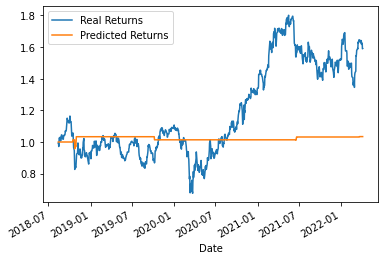

In [44]:
# Plot the real vs predicted values as a line chart
(1 + results[["Real Returns", "Predicted Returns"]]).cumprod().plot()

## Use MFI INDICATOR to predict CLOSE price

In [101]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [115]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 5

# Column index 1 is the 'MFI' column
# Column index 0 is the `PCT Change` column
feature_column = 1
target_column = 0
X, y = window_data(cat_algo_df, window_size, feature_column, target_column)

In [116]:
# Use 70% of the data for training and the remaineder for testing
split = int(0.7 * len(X))
X_train = X[:split]
X_test = X[split:]
y_train = y[:split]
y_test = y[split:]

In [117]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.
scaler = MinMaxScaler()

scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y_train)

y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [118]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],1))

In [119]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

model = Sequential()

number_units = 10
dropout_fraction = 0.2
# Layer 1
model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output Layer
model.add(Dense(1))

In [120]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [121]:
# Summarize the model
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 5, 10)             480       
_________________________________________________________________
dropout_15 (Dropout)         (None, 5, 10)             0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 10)                840       
_________________________________________________________________
dropout_16 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 11        
Total params: 1,331
Trainable params: 1,331
Non-trainable params: 0
_________________________________________________________________


In [122]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 2146 samples
Epoch 1/10
2146/2146 [==============================] - 8s 4ms/sample - loss: 0.0021
Epoch 2/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0028
Epoch 3/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0029
Epoch 4/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0033
Epoch 5/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0033
Epoch 6/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0034
Epoch 7/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0036
Epoch 8/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0040
Epoch 9/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0040
Epoch 10/10
2146/2146 [==============================] - 6s 3ms/sample - loss: 0.0039


In [123]:
# Evaluate the model
model.evaluate(X_test,y_test)

921/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

0.1469414331419363

In [124]:
# Make some predictions
predicted = model.predict(X_test)

In [125]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [126]:
# Create a DataFrame of Real and Predicted values
results_close = pd.DataFrame({
    "Real Close": real_prices.ravel(),
    "Predicted Close": predicted_prices.ravel()
}, index = new_df.index[-len(real_prices): ]) 
results_close.head()

,Real Close,Predicted Close
Date,,
2018-08-10,38.599998,30.930437
2018-08-13,41.650002,31.866137
2018-08-14,35.700001,33.244244
2018-08-15,32.900002,34.132393
2018-08-16,30.450001,34.313725


In [127]:
# Plot the real vs predicted values as a line chart
results_close.hvplot()

:NdOverlay   [Variable]
   :Curve   [Date]   (value)